In [1]:
from DORA_XGB import DORA_XGB
import os
from pathlib import Path
from src.utils import load_json, save_json
import pandas as pd
from collections import defaultdict
import numpy as np
from itertools import combinations, product
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

Basic usage

In [2]:
model = DORA_XGB.feasibility_classifier(cofactor_positioning='add_subtract')
rxn = "OC(C(C)=O)=O.O=C=O.NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)C=CC1>>NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)c1.OC(C(O)CC(O)=O)=O"
model.predict_proba(rxn)

0.93577456

In [6]:
asset_path = Path(os.environ.get("BOTTLE_EXPANSION_ASSETS"))

In [7]:
prs = load_json(asset_path / 'predicted_reactions.json')
krs = load_json(asset_path / 'known_reactions.json')

In [8]:
krs[list(krs.keys())[0]]

{'id': 'Re69b39c63c0593fa41a1cec058394da2e621d3af1d43615aea5f8382dfc37fec',
 'smarts': 'CCC(C)(C)C(=O)O.NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)C=CC1.O=O>>CC(O)C(C)(C)C(=O)O.NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)c1.O',
 'operators': ['rule0004_13'],
 'reaction_center': [[1], [3, 4, 5, 45, 46, 47], [0, 1]],
 'analogues': ['6615',
  '7757',
  '8249',
  '8882',
  '10657',
  '11512',
  '12345',
  '12354',
  '13347',
  '14012',
  '14248',
  '15049',
  '16106',
  '16109',
  '16276',
  '17631',
  '18901',
  '19299',
  '19387',
  '19494'],
 'rcmcs': {'6615': 0.6842105263157895,
  '7757': 0.6666666666666666,
  '8249': 0.6046511627906976,
  '8882': 0.6582278481012658,
  '10657': 0.6341463414634146,
  '11512': 0.65,
  '12345': 0.6923076923076923,
  '12354': 0.6666666666666666,
  '13347': 0.5977011494252874,
  '14012': 0.7323943661971831,
  '14248': 0.6923076923076923,
  '15049': 0.5909090909090909,
  '

In [9]:
data = defaultdict(list)
dxgb_variants = {
    elt: DORA_XGB.feasibility_classifier(cofactor_positioning=elt) 
    for elt in ['add_concat', 'by_ascending_MW', 'by_descending_MW', 'add_subtract']
}


In [ ]:

for k, v in prs.items():
    if v['rcmcs']:
        data['id'].append(k)
        data['smarts'].append(v['smarts'])
        rcmcses = np.array(list(v['rcmcs'].values()))
        data['min'].append(rcmcses.min())
        data['max'].append(rcmcses.max())
        data['mean'].append(rcmcses.mean())

        for vari, clf in dxgb_variants.items():
            data[vari].append(clf.predict_proba(v['smarts']))
            

In [40]:
df = pd.DataFrame(data=data)
df.head()

,id,smarts,min,max,mean,add_concat,by_ascending_MW,by_descending_MW,add_subtract
0,Re69b39c63c0593fa41a1cec058394da2e621d3af1d436...,CCC(C)(C)C(=O)O.NC(=O)C1=CN(C2OC(COP(=O)(O)OP(...,0.590909,0.800000,0.681890,0.877720,0.815247,0.515109,0.798800
1,R022d15344a76dbd79cf46e8c67679ce6aff193011ecd9...,CC(C)(C)C(=O)O.NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=...,0.590909,0.815385,0.693984,0.512218,0.182297,0.669815,0.479952
2,R17b5116b7d8f16bf7d458ac6b368477df85a3f4374ad6...,CC(C)(C)C(=O)O.O>>CC(C)(CO)C(O)O,0.333333,0.555556,0.429630,0.002350,0.055539,0.015200,0.057002
3,R20d0f82c8e2a0f6b78fe2ce671550d4a93ed831781dc9...,CC(C)(CO)C(O)O.NC(=O)c1ccc[n+](C2OC(COP(=O)(O)...,0.578313,0.875000,0.745687,0.085922,0.003096,0.031963,0.060829
4,R8d6935b7dc7e53b7763a6794f33a0bb67f1a2ac2f0509...,CC(C)(CO)C(O)O.*C1=C(*)C(=O)C(*)=C(*)C1=O>>CC(...,0.800000,0.800000,0.800000,0.408923,0.462119,0.768282,0.827314


In [50]:
df.corr(method='pearson', numeric_only=True)

,min,max,mean,add_concat,by_ascending_MW,by_descending_MW,add_subtract
min,1.000000,0.620948,0.908066,0.209351,0.164027,0.210706,0.152355
max,0.620948,1.000000,0.865230,0.468588,0.415021,0.470141,0.287216
mean,0.908066,0.865230,1.000000,0.373385,0.318521,0.372316,0.236646
add_concat,0.209351,0.468588,0.373385,1.000000,0.758501,0.827997,0.594216
by_ascending_MW,0.164027,0.415021,0.318521,0.758501,1.000000,0.786912,0.540050
by_descending_MW,0.210706,0.470141,0.372316,0.827997,0.786912,1.000000,0.567534
add_subtract,0.152355,0.287216,0.236646,0.594216,0.540050,0.567534,1.000000


In [51]:
df.corr(method='spearman', numeric_only=True)

,min,max,mean,add_concat,by_ascending_MW,by_descending_MW,add_subtract
min,1.000000,0.631148,0.889136,0.295007,0.199501,0.309311,0.264073
max,0.631148,1.000000,0.877310,0.519099,0.374328,0.524377,0.323389
mean,0.889136,0.877310,1.000000,0.456462,0.314862,0.460799,0.308259
add_concat,0.295007,0.519099,0.456462,1.000000,0.794054,0.889490,0.718760
by_ascending_MW,0.199501,0.374328,0.314862,0.794054,1.000000,0.802254,0.628282
by_descending_MW,0.309311,0.524377,0.460799,0.889490,0.802254,1.000000,0.699035
add_subtract,0.264073,0.323389,0.308259,0.718760,0.628282,0.699035,1.000000


In [89]:
df['add_concat'].to_numpy().size

3394

In [101]:
def bootstrap_spearman(x, y, n, rng):
    rs = []
    x = x.reshape(-1,)
    y = y.reshape(-1,)

    if x.shape != y.shape:
        raise ValueError("Dimensions must match")
    
    idxs = np.arange(x.size)
    for _ in range(n):
        rng.shuffle(idxs)
        res = spearmanr(x[idxs], y)
        rs.append(res.statistic)

    return np.array(rs)

x = df['max'].to_numpy()
y = df['add_concat'].to_numpy()
n=10_000
test = 0.524377
rng = np.random.default_rng(seed=1234)
spearman_bs_distr = bootstrap_spearman(x, y, n, rng)
pval = 1 - (spearman_bs_distr < test).sum() / spearman_bs_distr.size 
print(f"p={pval}")

p=0.0


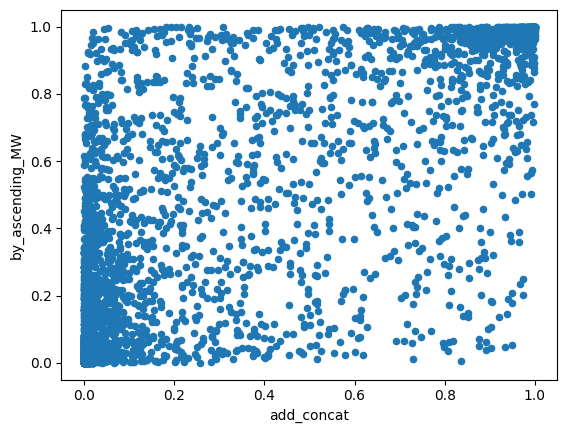

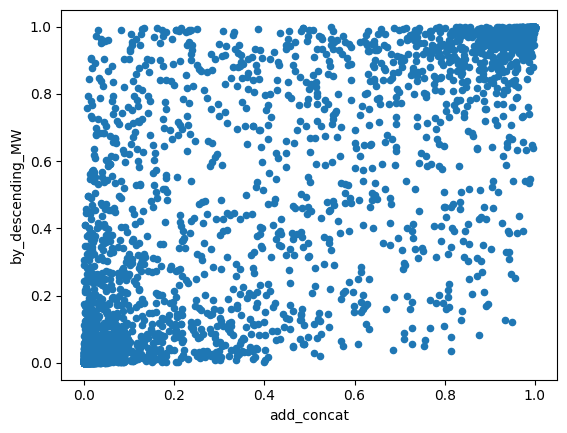

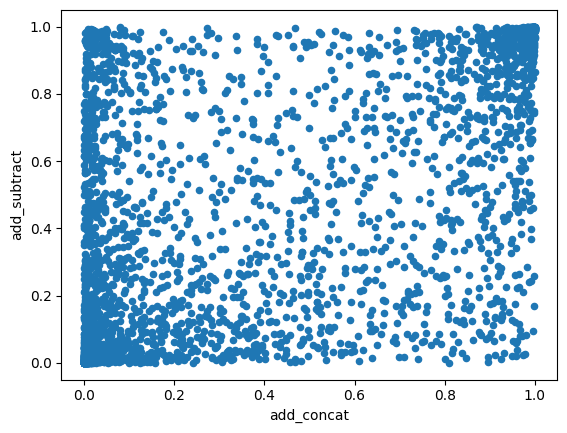

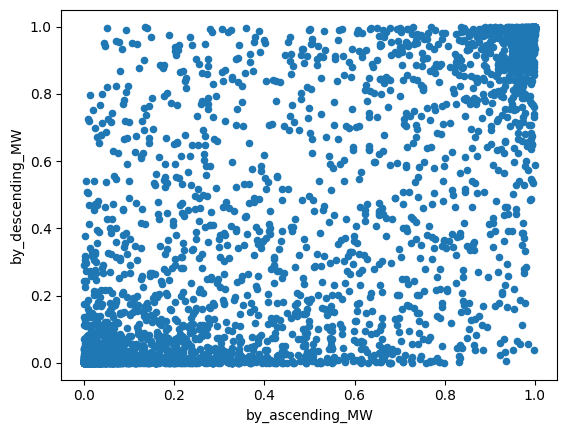

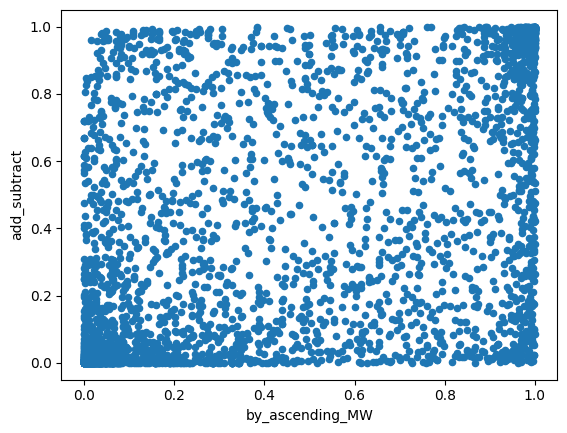

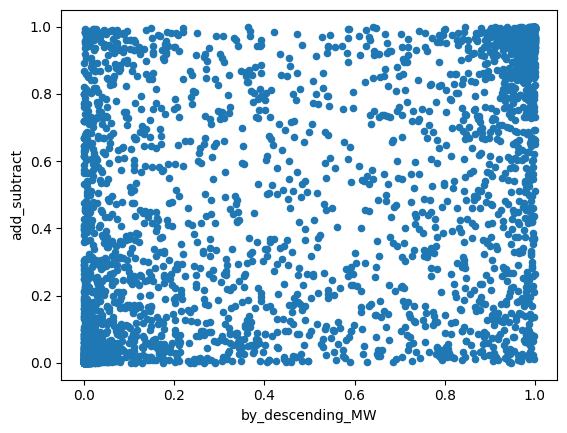

In [46]:
internal_combos = combinations(dxgb_variants.keys(), 2)
for xlab, ylab in internal_combos:
    df.plot.scatter(x=xlab, y=ylab)

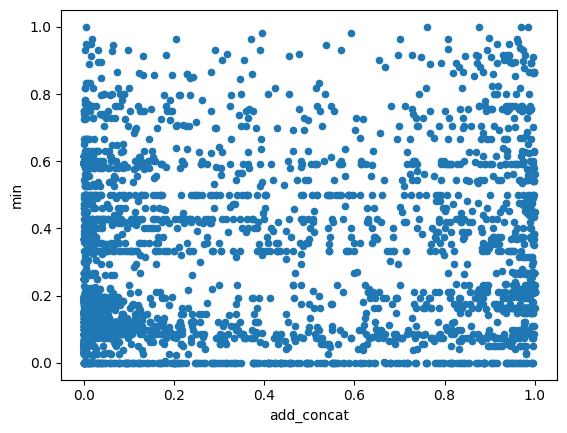

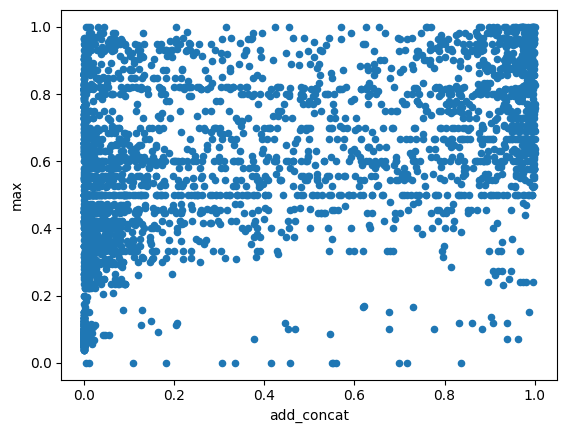

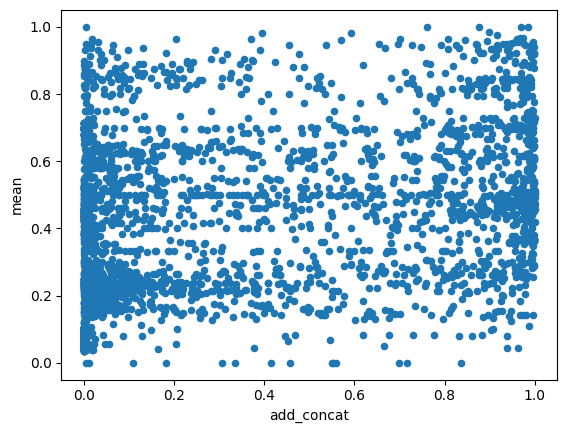

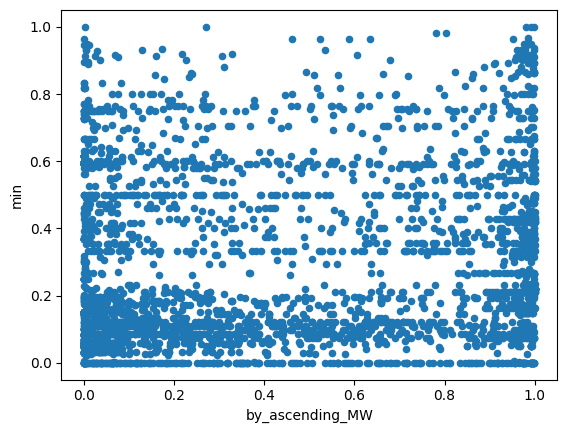

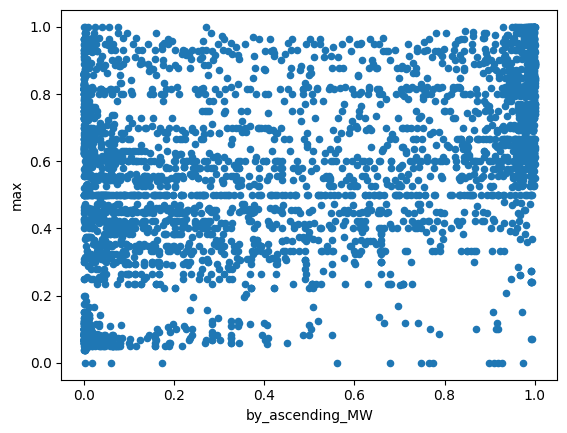

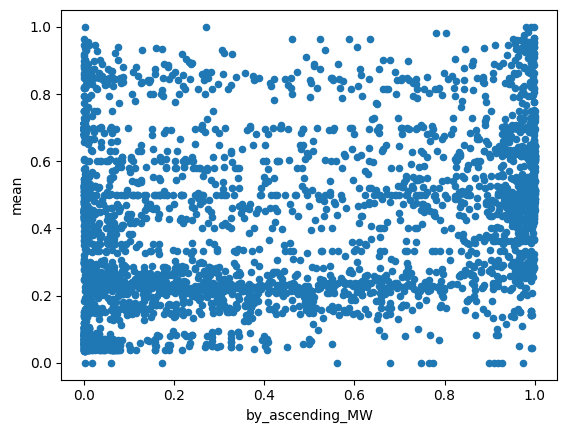

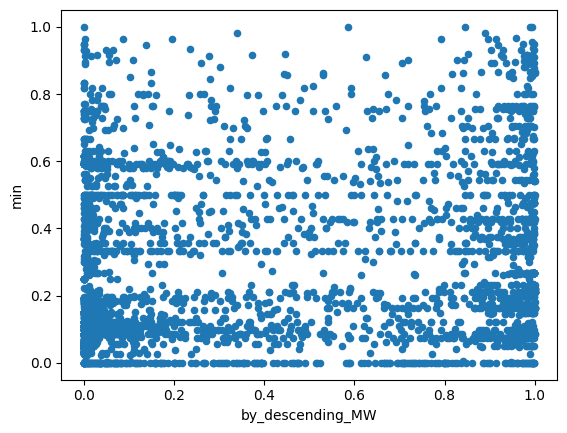

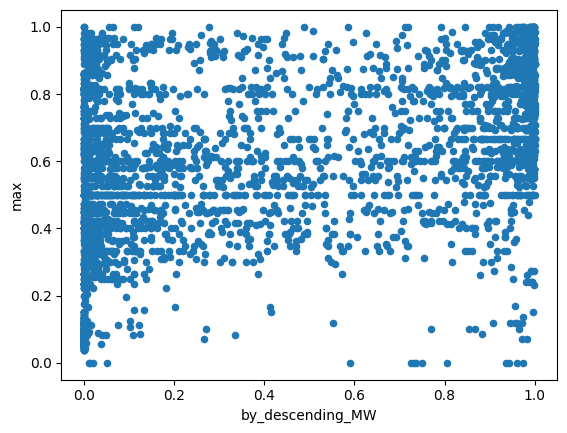

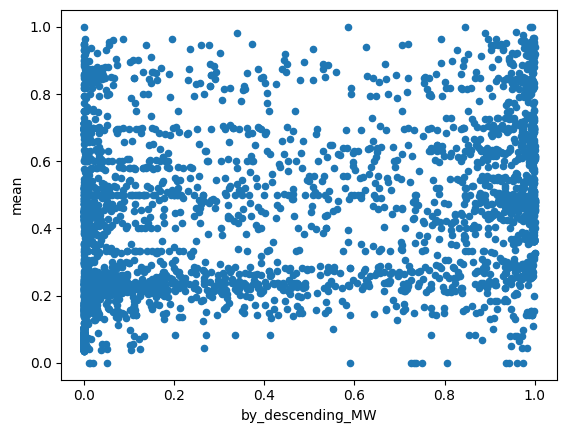

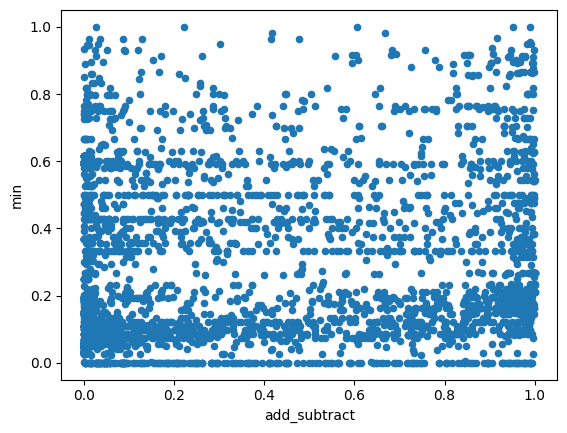

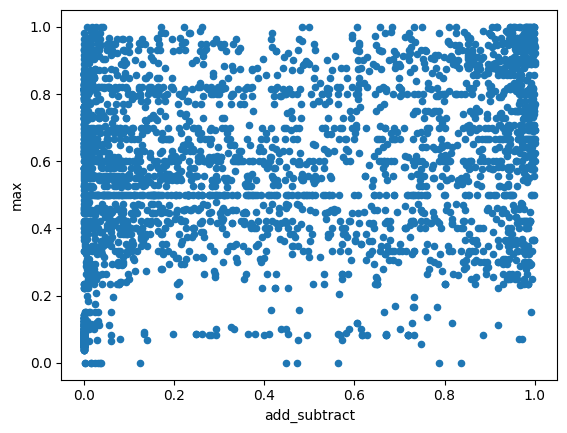

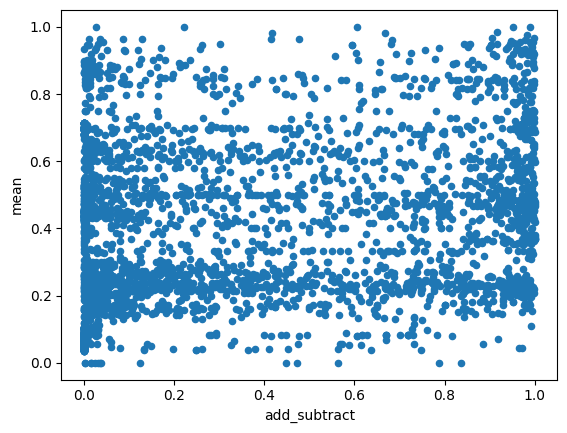

In [48]:
external_combos = product(dxgb_variants.keys(), ['min', 'max', 'mean'])
for xlab, ylab in external_combos:
    df.plot.scatter(x=xlab, y=ylab)

In [76]:
type(prs[list(prs.keys())[0]]['feasibility'])

numpy.float32

In [10]:
for k, v in prs.items():
    try:
        v['feasibility'] = float(dxgb_variants['add_concat'].predict_proba(v['smarts']))
    except:
        v['feasibility'] = float(-1)

In [11]:
# save_json(prs, asset_path / 'predicted_reactions.json')

In [81]:
from src.chem_draw import draw_reaction
from IPython.display import SVG

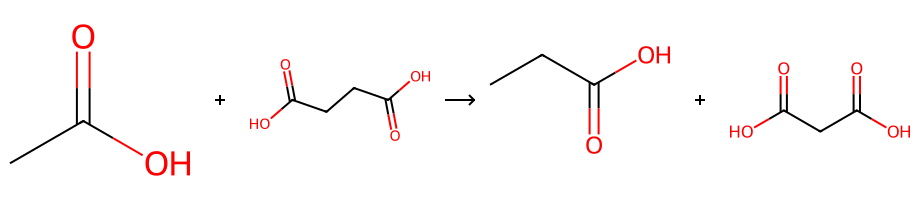

add_concat >> 0.774084210395813 >> 1
by_ascending_MW >> 0.7186757922172546 >> 1
by_descending_MW >> 0.9436923861503601 >> 1
add_subtract >> 0.739837110042572 >> 1


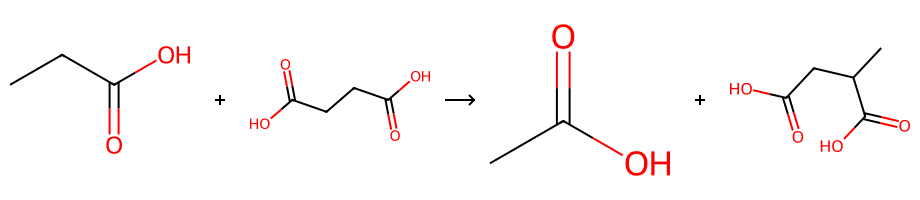

add_concat >> 0.926760196685791 >> 1
by_ascending_MW >> 0.9912627935409546 >> 1
by_descending_MW >> 0.9364835023880005 >> 1
add_subtract >> 0.18460269272327423 >> 0


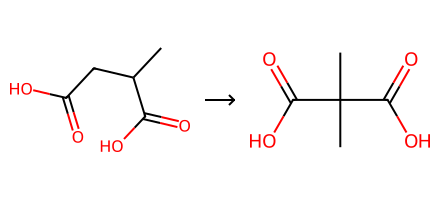

add_concat >> 0.3320715129375458 >> 0
by_ascending_MW >> 0.6553725004196167 >> 1
by_descending_MW >> 0.44674310088157654 >> 0
add_subtract >> 0.09316336363554001 >> 0


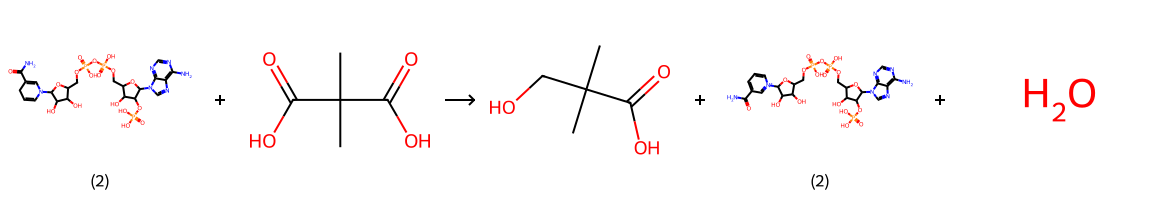

add_concat >> 0.9454461336135864 >> 1
by_ascending_MW >> 0.37955522537231445 >> 0
by_descending_MW >> 0.9690408706665039 >> 1
add_subtract >> 0.8546804189682007 >> 1


In [84]:
rids = ['R8de73ff29bc9a7faeffa1e48d8720dc58a60a32862f53de4bf205f3cd22b2a04',
 'R67ad4fc6c8a9393f5111436eca9cf30f3e6732d6a8c5e0fee5b7a43adcea31de',
 'R889723c45853b5eaff91424ea5886b7fb2ac9a155b8c60622882341dd333820c',
 'R2f625c2659df0dc72b87de746a65d26cc617c32d512fa5b8a8ee5443a5d10d2e']

for elt in rids:
    display(
        SVG(
            draw_reaction(
                prs[elt]['smarts']
            ).to_str()
        )
    )

    for vari, clf in dxgb_variants.items():
        print(f"{vari} >> {clf.predict_proba(prs[elt]['smarts'])} >> {clf.predict_label(prs[elt]['smarts'])}")